# ICON 2017 workshop: MVPA of fMRI data in Python (ANSWERS)
Notebook with answers to the ToDo/ToThink questions.

<div class='alert alert-info'>
**ToThink**: Decide for the following scenarios whether they correspond to a **within-subject** or **between-subject** design!<br><br>

1. Subjects view a sequence of negative (violence, mutilation, war scenes) images during fMRI acquisition. One group of subjects are administered [propanolol](https://en.wikipedia.org/wiki/Propranolol) before the fMRI session and another group a placebo. The researcher in charge wants to see whether patterns in the insula change in reponse to propanolol using a pattern-based analysis. <br><br>

2. Subjects view images of scenes with either animate of inanimate objects during fMRI acquisition. The researcher wants to decode "animacy" from patterns in the lateral occipital cortex.
</div>

### Answer
1. This is a between-subject design!
2. This is a within-subject design!

In [1]:
# First, we need to import some Python packages
import numpy as np
import pandas as pd
import os.path as op
import warnings
import matplotlib.pyplot as plt
plt.style.use('classic')
warnings.filterwarnings("ignore")
%matplotlib inline

In [57]:
# The onset times are loaded as pandas dataframe with three columns: 
# onset times (in seconds) (column 1), durations (column 2), and conditions (column 3).
# N.B.: condition 0 = passive, condition 1 = active
stim_info = pd.read_csv(op.join('example_data', 'onsets.csv'), sep='\t',
                        names=['onset', 'duration', 'trial_type'])

Remember, the onsets (and duration) are here defined in seconds (not TRs). Let's assume that the fMRI-run has a TR of 2. Now, we can convert (very easily!) the onsets/durations-in-seconds to onsets/durations-in-TRs.

In [3]:
stim_info[['onset', 'duration']] = (stim_info[['onset', 'duration']] / 2).astype(int)

To perform the first-level analysis, for each regressor (trial) we need to create a regressor of zeros and ones, in which the ones represent the moments in which the particular trial was presented. Let's assume that our moment of interest is the encoding phase, which lasts only 2 seconds; we thus can model it as an "impulse".

So, for example, if you have a (hypothetical) run with a total duration of 15 TRs, and you show a stimulus at TR=3 for the duration of 1 TRs (i.e. 2 seconds), then you'd code your regressor as:

`[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

<div class='alert alert-warning'>
**ToDo**: Below, we initialized a stimulus vector (`stim_vec`) of shape=[162, 40], i.e. timepoints x trials (this run was 162 TRs long), with zeros. Each of the 40 rows represents one trial. Loop over the colums of the `stim_vec` matrix and fill the times at onset till the onset + 2 TRs with ones. Remember, the first index in Python is zero (not 1!).
</div>

In [4]:
# ANSWER
n_trials = 40
stim_vec = np.zeros((162, n_trials))

for itrial in range(n_trials):
    idx = stim_info['onset'][itrial]
    stim_vec[idx, itrial] = 1

In [5]:
np.testing.assert_array_equal(stim_vec, np.load('example_data/stim_vec.npy'))
print("Well done!")

Well done!


#### 1.4.1 tips & tricks to load and transform (nifti-)files
As a first thing, we need to find all the paths to the *t*-stat nifti-files. Python has a nifty (pun intended) tool called "`glob`" which can find files/directories on disk using [wildcards](https://en.wikipedia.org/wiki/Wildcard_character). It is usually imported as follows:

In [6]:
from glob import glob

`glob`, in Python, is a function that takes a path (as a string) with one or more wildcard characters (such as the `*`) and searches for files/directories on disk that match that. For example, let's try to find all the png-imagesin the "img" directory using glob (these are the images that I used inside this notebook). 

In [7]:
import os
# the images are in img/ on Linux/Mac systems, but in img\ on Windows (hence the "os.sep" thingie)
my_search_string = 'img' + os.sep + '*.png'
png_files = glob(my_search_string)
print(png_files)

['img/within_subject_example.png', 'img/skbold_scope.png', 'img/WM_example.png', 'img/pattern_estimation.png', 'img/fslview.png', 'img/viz.png', 'img/sklearn_transformers.png', 'img/obj_class_diff.png', 'img/pipelinesX.png', 'img/screenshot_within.png', 'img/single_trial_design.png', 'img/data_representation.png']


As you can see, it returns a list with all the files/directories that matched the search-string. Note that you can also search files outside of the current directory. To do so, we can simply specify the relative or absolute path to it.

<div class='alert alert-warning'>
**ToDo**: Now you have the skills to actually "glob" all the *t*-stats from subject `pi0070` yourself! Use glob to find all the paths to the t-stats and store the results (a list with 40 strings) in a variable called `tstat_paths`. Note: the data directory is one directory above the current directory! Hint: watch out! There might be an `ftest.nii.gz` file in the stats-directory ...
</div>

In [8]:
# ANSWER
tstat_paths = glob(op.join('..', 'data', 'pi0070', 'wm.feat', 'stats', 'tstat*.nii.gz'))

In [9]:
# To check your answer, run this cell
assert(len(tstat_paths) == 40)
print("Well done! You globbed all the 40 tstat-files correctly!")

Well done! You globbed all the 40 tstat-files correctly!


To fix this issue, we wrote a little function (`sort_nifti_paths()`) that sorts the paths correctly. (If you're interested in how it works, check out the functions.py file.)

In [12]:
# Let's fix it
from functions import sort_nifti_paths
tstat_paths = sort_nifti_paths(tstat_paths)

In [13]:
import nibabel as nib
data = nib.load(tstat_paths[0]).get_data()

<div class='alert alert-warning'>
**ToDo**: in the code block below, write a loop that loads in the tstat nifti-files one by one (using nibabel) and store them in the already preallocated array "X". Note that "X" is a 2D matrix (samples-by-features), but each tstat-file contains a 3D array, so you need to "flatten" the 3D array to a single vector: use e.g. the numpy function "flatten()" or "ravel()". 
</div>

In [14]:
# ANSWER
voxel_dims = (80, 80, 37) # The data is in EPI-space
X = np.zeros((len(tstat_paths), np.prod(voxel_dims)))

for trial, tstat_path in enumerate(tstat_paths):
    data = nib.load(tstat_path).get_data()
    data = data.ravel()
    X[trial,:] = data

In [15]:
# Can we check if X is correct here? Would be a good check before continuing to part 2
np.testing.assert_almost_equal(X, np.load('example_data/X_section1.npz')['X'])
print("Well done!")

Well done!


## Part 2. Multivoxel pattern analysis


### 2.1 Adding the dependent variable y
In Section 1.3, you ended with a nice 2D-matrix of N-samples x N-features. This 2D-matrix contains all whole-brain patterns of *t*-values for all trials: this is your **X**. However, this leaves out a crucial part of the data: the actual feature-of-interest, *trial type*, your **y**.

While there is kind of a generic way to load in voxel patterns, there is usually not a single way to load in your dependent variable (y), because the exact factor that represents `y` dependent on your exact research question (and also depends how you have stored this data on disk). 

In within-subject single-trial designs, trial type or condition is often the dependent variable. The dependent variable can thus be extracted from your design. In fact, we already loaded the dependent variable previously, in the `onsets` variable (see Section 1.2). The third column named 'trial_type') contains the trial types, where 1 is an "ACTIVE" trial and 0 a "PASSIVE" trial.

<div class='alert alert-warning'>
**ToDo**: Extract vector *y* from `onsets`, which only contains the trial types (i.e., y = [1, 1, 1, 0, ..., 0, 1, 1]) 
</div>

In [16]:
# ANSWER
y = stim_info['trial_type'].values

#### Check your answer

In [17]:
np.testing.assert_equal(np.array(y), np.load('example_data/y.npy'))
print('Well done!')

Well done!


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Here we initialize the StandardScaler object
scaler.fit(X)             # Here we "fit" the StandardScaler to our entire dataset (i.e. calculates means and stds of each feature)
X = scaler.transform(X)   # And here we transform the dataset using the calculated means/stds

Did the scaling procedure work? Let's check that below (by asserting that the mean of each column is 0, and the std of each column is 1):

In [19]:
means = np.mean(X, axis=0)
np.testing.assert_almost_equal(means, np.zeros(X.shape[1]))
print("Each column (feature) has mean 0!")
stds = X.std(axis=0)
np.testing.assert_almost_equal(stds[stds != 0], np.ones((stds != 0).sum()))
print("Each column (feature) has std 1!")

Each column (feature) has mean 0!
Each column (feature) has std 1!


In [20]:
# Scikit-learn is always imported as 'sklearn'
from sklearn.svm import SVC

In [21]:
# clf = CLassiFier
clf = SVC(kernel='linear')

In [22]:
print('Fitting SVC ...', end='')
clf.fit(X, y)
print(' done.')

Fitting SVC ... done.


In [23]:
coefs = clf.coef_
print("Shape of coefficients: %r" % (coefs.shape,))

Shape of coefficients: (1, 236800)


In [24]:
y_hat = clf.predict(X)
print("The predictions for my samples are:\n %r" % y_hat.tolist())

The predictions for my samples are:
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


<div class='alert alert-warning'>
**ToDo**: The cool thing about scikit-learn is that their objects have a very consistent API and have sensible defaults. As a consequence, *every* model ("estimator" in scikit-learn terms) is used in the same way using the `fit(X, y)` and `predict(X)` methods. Try it out yourself below!<br><br> Try using the [LinearDiscriminantAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) class (`from sklearn.discriminant_analysis import LinearDiscriminantAnalysis`) or [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) ("Naive Bayes" classifier; `from sklearn.naive_bayes import GaussianNB`) for example (or any other!). All methods should work exactly the same as the previous example using the SVM.
</div>

In [27]:
# ANSWER
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda.predict(X)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

<div class='alert alert-warning'>
**ToDo**: Can you calculate the accuracy of the above model? Hint 1: you need to compare the true labels (i.e. y) with the predicted labels (i.e. y_hat). Hint 2: if you do arithmetic with boolean values (i.e. `True` and `False`), `True` is interpreted as 1 and `False` is interpreted as 0.
</div>

In [28]:
# ANSWER
accuracy = (y_hat==y).mean() 
print(accuracy)

# or alternatively
accuracy = (y_hat == y).sum() / y.size # or: len(y)

# or using scikit-learn metrics
from sklearn.metrics import accuracy_score
accuracy_score(y, y_hat)

1.0


1.0

In [29]:
from sklearn.model_selection import train_test_split

if not isinstance(y, np.ndarray):
    y = np.array(y)

# The argument "test_size" indicates the test-size as a proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y,
                                                    random_state=5)
    
print("Shape X_train: %r" % (X_train.shape,))
print("Shape y_train: %r" % (y_train.shape,))
print("Shape X_test: %r" % (X_test.shape,))
print("Shape y_test: %r" % (y_test.shape,))

Shape X_train: (20, 236800)
Shape y_train: (20,)
Shape X_test: (20, 236800)
Shape y_test: (20,)


<div class='alert alert-warning'>
**ToDo**: To convince yourself that the `stratify` option does what it supposed to do, check whether the class-ratio is the same for the train and test-set. 
</div>

In [30]:
# ANSWER
is_equal_ratio = y_train.mean() == y_test.mean()
print("Is the class-ratio the same? --> %s (namely %.1f)" % (is_equal_ratio, y_train.mean()))

Is the class-ratio the same? --> True (namely 0.8)


<div class='alert alert-warning'>
**ToDo**: Fit your model on `X_train` and `y_train` and then predict `X_test`. Calculate both the accuracy on the train-set (fit and predict on train) *and* the cross-validated accuracy (fit on train, predict on test). Compare the two accuracies - are we overfitting the model?
</div>

In [ ]:
# ANSWER
clf.fit(X=X_train, y=y_train)
y_hat_train = clf.predict(X=X_train)
y_hat_test = clf.predict(X=X_test)

print("Accuracy train: %.3f" % (y_hat_train == y_train).mean())
print("Accuracy test: %.3f" % (y_hat_test == y_test).mean())

<div class='alert alert-warning'>
**ToDo**: Evaluate the model from the previous ToDo with the ROC-AUC-score metric instead of accuracy. Check both the performance on the train-set (which should still be 1.0) and the (cross-validated) performance on the test-set.
Notice the drop in performance compared to using accuracy!
</div>

In [ ]:
# ANSWER
clf.fit(X=X_train, y=y_train)
y_hat_train = clf.predict(X=X_train)
y_hat_test = clf.predict(X=X_test)

print("ROC-AUC train: %.3f" % roc_auc_score(y_train, y_hat_train))
print("ROC-AUC test: %.3f" % roc_auc_score(y_test, y_hat_test))

In [31]:
# scikit-learn is imported as 'sklearn'
from sklearn.model_selection import StratifiedKFold

# They call folds 'splits' in scikit-learn
skf = StratifiedKFold(n_splits=5)

In [32]:
folds = skf.split(X, y)

In [33]:
# Notice how we "unpack" the train- and test-indices at the start of the loop
i = 1
for train_idx, test_idx in folds:
    
    print("Processing fold %i" % i)
    print("Train-indices: %s" % train_idx)
    print("Test-indices: %s\n" % test_idx)
    
    i += 1

Processing fold 1
Train-indices: [ 8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
Test-indices: [ 0  1  2  3  4  5  6  7 13]

Processing fold 2
Train-indices: [ 0  1  2  3  4  5  6  7 13 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
Test-indices: [ 8  9 10 11 12 14 15 16 20]

Processing fold 3
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 20 25 27 28 29 30 31 32
 33 34 35 36 37 38 39]
Test-indices: [17 18 19 21 22 23 24 26]

Processing fold 4
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 32 33 34 35 37 38 39]
Test-indices: [25 27 28 29 30 31 36]

Processing fold 5
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 36]
Test-indices: [32 33 34 35 37 38 39]



<div class='alert alert-warning'>
**ToDo**: in the code-cell below, complete the statements by indexing X and y to create four different objects in every fold: X_train, y_train, X_test, y_test. Also, we created a new classifier-object (clf) for you based on a different model: scikit-learn's `LogisticRegression` to show you that *every* model in scikit-learn works the same (i.e. has the same `fit` and `predict` methods). <br><br>

Use this classifier to fit on the train-set and predict the test-set in every fold. Then, calculate the (cross-validated) performance (e.g. ROC-AUC-score) in every fold. Keep track of the accuracies across folds, and after the loop over folds, calculate the average performance across folds.
</div>

In [35]:
# EXAMPLE ANSWER
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(X, y)

performance = np.zeros(skf.n_splits)

for i, (train_idx, test_idx) in enumerate(folds):
    
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    
    X_test = X[test_idx,:]
    y_test = y[test_idx]
    
    # ToDo: call fit (on train) and predict (on test)
    model = clf.fit(X=X_train, y=y_train)
    y_hat = model.predict(X=X_test)
    
    # ToDo: calculate accuracy
    performance[i] = roc_auc_score(y_test, y_hat)

# ToDo: calculate average accuracy
print('Mean performance: %.3f' % np.mean(performance))

Mean performance: 0.669


In [36]:
X_r = np.random.randn(80, 1000)
print("Shape of X: %s" % (X_r.shape, ), '\n')

y_r = np.tile([0, 1], 40)
print("Shape of y: %s" % (y_r.shape, ))
print("Y labels:\n%r" % y_r.tolist(), '\n')
runs = np.repeat([1, 2, 3, 4], 20)
print("Shape of runs: %s" % (runs.shape, ))
print("Run-indices: \n%r" % runs.tolist())

Shape of X: (80, 1000) 

Shape of y: (80,)
Y labels:
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] 

Shape of runs: (80,)
Run-indices: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Now, scikit-learn offers a nice cross-validation class that partitions your data according to a "grouping" variable: `GroupKFold`, or variations thereof like `LeaveOneGroupOut` of `LeavePGroupsOut`. Let's check out how that can be used using our simulated data:

In [37]:
# Import from model_selection module
from sklearn.model_selection import GroupKFold

# In fact, when we initialize GroupKFold with 4 splits, as below, it is exactly the same as
# the LeaveOneGroupOut cross-validator, since we only have 4 groups
gkf = GroupKFold(n_splits=4)
for train_idx, test_idx in gkf.split(X=X_r, y=y_r, groups=runs):
    
    print("Indices of our test-samples: %r" % test_idx.tolist())
    print("... which correspond to following runs: %r" % runs[test_idx].tolist(), '\n')

Indices of our test-samples: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
... which correspond to following runs: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 

Indices of our test-samples: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
... which correspond to following runs: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] 

Indices of our test-samples: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
... which correspond to following runs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 

Indices of our test-samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
... which correspond to following runs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 



<div class='alert alert-info'>
**ToThink**: While stratification can be ensured by using e.g. `StratifiedKFold` cross-validators, stratification cannot be guaranteed when using `GroupKFold`. Why do you think this is the case? 
</div>

### Answer
Because your "conditioning" your folds on your runs. If your samples are imbalanced within runs, stratified folds cannot be guaranteed.

<div class='alert alert-warning'>
**ToDo**: Below, try to implement a *repeated random splits* cross-validation routine using `StratifiedShuffleSplit` with 100 repetitions and a test-size of 0.2! Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) for more info about its parameters.
</div>

In [39]:
# ANSWER
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2)

<div class='alert alert-info'>
**ToThink**: Suppose a researcher wants to decode gratings with two different orientations from V1. To delineate V1, the subject underwent a retinotopy session in a *different* fMRI run. The data from this retinotopy session was subsequently used to extract ("mask") V1 by excluding non-significant voxels; the significant voxels were in turn used to base the orientation decoding analysis on. <br><br>Is masking V1 using the retinotopy data a form of *feature selection* or *feature extraction*? Why? 
</div>

### Answer
This is feature-selection, because it *selects a subset of **voxels***, and it *doesn't* transform features into (lower dimensional) components.

<div class='alert alert-info'>
**ToThink**: What could be a reason to prefer feature selection above feature extraction? And the other way around? 
</div>

### Answer
Often, feature-selection is more interpretable, because your features are still expressed as a set of *voxels*. Using PCA-components of voxels, for example, are slightly less interpretable, because they're expressed as a weighted combination of voxels.

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif is a scikit-learn specific implementation of the F-test
select2000best = SelectKBest(score_func=f_classif, k=2000)

In [41]:
from sklearn.feature_selection import SelectFwe, chi2
selectfwe_transformer = SelectFwe(score_func=chi2, alpha=0.01)

But how does this work in practice? We'll show you an (not cross-validated!) example using the select100best transformer initialized earlier:

In [42]:
# Fit the transformer ...
select2000best.fit(X, y)

# ... which calculates the following attributes (.scores_ and .pvalues_)
# Let's check them out
scores = select2000best.scores_
pvalues =  select2000best.pvalues_

# As you can see, each voxel gets its own score (in this case: an F-score)
print(scores.size)

# and its own p-value:
print(pvalues.size)

236800
236800


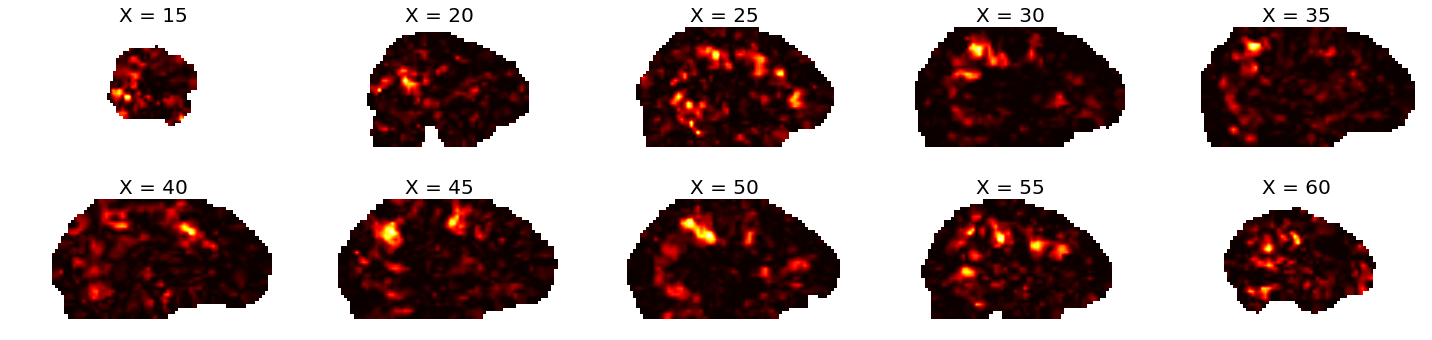

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

scores_3d = scores.reshape((80, 80, 37))
plt.figure(figsize=(20, 5))

for i, slce in enumerate(np.arange(15, 65, 5)):
    plt.subplot(2, 5, (i+1))
    plt.title('X = %i' % slce, fontsize=20)
    plt.imshow(scores_3d[slce, :, :].T, origin='lower', cmap='hot')
    plt.axis('off')
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
**ToThink**: Given the image above, what is the major difference between data driven feature selection (like UFS) and ROI-based feature selection (e.g. only look at patterns in the amygdala) in terms of the spatial scale of patterns you'll select? Try to think of an advantage of UFS over ROI-based feature selection and vice versa.
</div>

### Answer
UFS is blind to spatial scale, so you can extract spatially distributed set of voxels while ROI-based feature-selection (usually) assumes a spatially contiguous set of voxels.

<div class='alert alert-warning'>
**ToDo**: Below, we import the `PCA` class from scikit-learn. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Now, initialize an object from this `PCA`-class with the number of components to store set to 5, and subsequently fit in on `X_train_tmp` and subsequently call transform on `X_train_tmp` and `X_test_tmp` separately; store the result in the variables `X_train_pca_transformed` and `X_test_pca_transformed`. Then, check out the shape of `X_train_pca_transformed`: does it have the shape you expected?
</div>

In [44]:
# ANSWER
from sklearn.decomposition import PCA
X_train_tmp, X_test_tmp = train_test_split(X, test_size=0.5)

pca = PCA(n_components=5)
pca.fit(X_train_tmp)
X_train_pca_transformed = pca.transform(X_train_tmp)
X_test_pca_transformed = pca.transform(X_test_tmp)

print("Shape X_train (after PCA): %s" % (X_train_pca_transformed.shape,))
print("Shape X_test (after PCA): %s" % (X_test_pca_transformed.shape,))

Shape X_train (after PCA): (20, 5)
Shape X_test (after PCA): (20, 5)


<div class='alert alert-warning'>
**ToDo**: Below, we set up a K-fold cross-validation loop and prespecified a classifier (`clf`, a logistic regression model) and a transformer (`select1000best`, selecting the 1000 best features based upon an F-test). Now, it's up to you to actually implement the feature selection inside the for-loop. Make sure to fit the transformer only on the train-set, but then transform *both* the train-set and the test-set. Then, fit the model on the transformed train-set and cross-validate to the transformed test-set. Calculate performance (metric of your choice) of the cross-validated  model for each fold, and after all folds calculate the average performance (across folds).
</div>

In [46]:
# ANSWER
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(X, y)

performance = np.zeros(skf.n_splits)
select1000best = SelectKBest(score_func=f_classif, k=1000)

for i, (train_idx, test_idx) in enumerate(folds):
    
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    select1000best.fit(X=X_train, y=y_train)
    X_train = select1000best.transform(X=X_train)
    X_test = select1000best.transform(X=X_test)
    
    # ToDo: calculate accuracy
    clf.fit(X=X_train, y=y_train)
    y_test_hat = clf.predict(X=X_test)
    performance[i] = roc_auc_score(y_test, y_test_hat)

# ToDo: calculate average accuracy
print('Mean performance: %.3f' % np.mean(performance))

Mean performance: 0.810


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
ufs = SelectKBest(score_func=f_classif, k=1000)
pca = PCA(n_components=10)  # we want to reduce the features to 10 components
svc = SVC(kernel='linear')

In [48]:
from sklearn.pipeline import Pipeline

pipeline_to_make = [('preproc', scaler),
                    ('ufs', ufs),
                    ('pca', pca),
                    ('clf', svc)]

my_pipe = Pipeline(pipeline_to_make)

In [49]:
X_train, y_train = X[0::2], y[0::2]
X_test, y_test = X[1::2], y[1::2]

my_pipe.fit(X_train, y_train)
predictions = my_pipe.predict(X_test)
performance = roc_auc_score(y_test, predictions)
print("Cross-validated performance on test-set: %.3f" % performance)

Cross-validated performance on test-set: 0.719


<div class='alert alert-warning'>
**ToDo**: Test your pipeline-skills! Can you build a pipeline that incorporates a [VarianceThreshold](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) (removes all voxels outside the brain), K-means clustering (with 8 clusters, such that $K$ voxels --> 8 clusters, using [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html#sklearn.cluster.k_means)), scaling (`StandardScaler`), and a [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)?
</div>

In [50]:
# ANSWER
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('varthres', VarianceThreshold()),
    ('cluster', KMeans(15)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
])

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
performance = roc_auc_score(y_test, predictions)
print("Cross-validated performance on test-set: %.3f" % performance)

Cross-validated performance on test-set: 0.531


<div class='alert alert-warning'>
**ToDo**: Before we start, we need to get the participant numbers of all our participants. To find these, we can make use of the directory names. In Section **1.4.1** you learned the tricks you need to get all subdirectory names of the `data` directory using a wildcard!

</div>

In [51]:
# Example answer
participant_numbers = glob(op.join('..', 'data', 'pi*'))
print(participant_numbers)

# Next, we need to extract the participant numbers from the paths you just obtained. We do this for you here.
participant_numbers = [x.split('/')[-1] for x in participant_numbers]
print('\nThere are the participant numbers:\n%s' % participant_numbers)

['../data/pi0105', '../data/pi0145', '../data/pi0135', '../data/pi0130', '../data/pi0100', '../data/pi0085', '../data/pi0125', '../data/pi0110', '../data/pi0070', '../data/pi0075', '../data/pi0080', '../data/pi0115', '../data/pi0090', '../data/pi0095', '../data/pi0140', '../data/pi0120']

There are the participant numbers:
['pi0105', 'pi0145', 'pi0135', 'pi0130', 'pi0100', 'pi0085', 'pi0125', 'pi0110', 'pi0070', 'pi0075', 'pi0080', 'pi0115', 'pi0090', 'pi0095', 'pi0140', 'pi0120']


<div class='alert alert-warning'>
**ToDo** (optional!): This final ToDo is a big one, in which everything we learned so far comes together nicely. Write a loop over all participants, implementing a cross-valdidated classification pipeline including feature selection. We provide you with some "boilerplate" code to start with, but it's up to you to complete the analysis/loop.
<br><br>
Make sure to include the following:
<br>
    1. Scale the patterns (even better: cross-validate your scaler)<br>
    2. Use 5-fold Stratified cross-validation<br>
    3. Within each fold, select the best 100 features using an f_classif Selector<br>
    4. Use a SVM to decode condition from these 100 features<br><br>
    
Optional:<br>
- Use a scikit-learn Pipeline in which you group your scaler, selector, and estimator!<br><br>

Hints:<br>
- The design for each subject was exactly the same, so you can use the same "y" as in the previous example!<br>

</div>

In [52]:
# ANSWER

skf = StratifiedKFold(n_splits=5)
select100best = SelectKBest(f_classif, k=100)
clf = SVC(kernel='linear')
pipe = Pipeline([('scaler', StandardScaler()), ('ufs', select1000best), ('clf', clf)])

all_performance = np.zeros(len(participant_numbers))

### Start loop over subjects ###
for i_sub, participant_number in enumerate(participant_numbers):
    
    path_this_participant = op.join('..', 'data', participant_number, 'wm.feat', 'stats', 'tstat*.nii.gz')
    t_stat_paths_this_participant = sort_nifti_paths(glob(path_this_participant))
    voxel_dims = nib.load(t_stat_paths_this_participant[0]).header.get_data_shape()
    X = np.zeros((len(t_stat_paths_this_participant), np.prod(voxel_dims)))

    for trial, tstat_path in enumerate(t_stat_paths_this_participant):
        data = nib.load(tstat_path).get_data()
        data = data.ravel()
        X[trial,:] = data
    
    performance_this_participant = np.zeros(skf.n_splits)
    
    # Loop over the folds
    for i_fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        performance = roc_auc_score(y_test, preds)        
        performance_this_participant[i_fold] = performance

    mean_performance_this_participant = performance_this_participant.mean()
    print('Mean performance for participant %s: %.3f' % (participant_number, mean_performance_this_participant))
    
    all_performance[i_sub] = mean_performance_this_participant

print('\nFinal performance mean (std): %.3f (%.3f)' % (all_performance.mean(), all_performance.std()))

Mean performance for participant pi0105: 0.700
Mean performance for participant pi0145: 0.519
Mean performance for participant pi0135: 0.783
Mean performance for participant pi0130: 0.900
Mean performance for participant pi0100: 0.950
Mean performance for participant pi0085: 0.700
Mean performance for participant pi0125: 0.900
Mean performance for participant pi0110: 0.683
Mean performance for participant pi0070: 0.836
Mean performance for participant pi0075: 1.000
Mean performance for participant pi0080: 0.700
Mean performance for participant pi0115: 0.900
Mean performance for participant pi0090: 0.833
Mean performance for participant pi0095: 0.900
Mean performance for participant pi0140: 0.983
Mean performance for participant pi0120: 0.886

Final performance mean (std): 0.823 (0.127)


In [55]:
from scipy.stats import ttest_1samp

<div class='alert alert-warning'>
**ToDo**: Do the one-sample t-test! Can we decode the condition with a significantly above-chance accuracy?

</div>

In [56]:
# Example answer
t, p = ttest_1samp(all_performance, 0.5)
print('The t-value is %.3f, with a p-value of %.5f' % (t, p))

The t-value is 9.826, with a p-value of 0.00000


Finally, we can draw our conclusions: can we decode trial condition, using the fMRI data, with an above-chance accuracy? (Yes we can! But remember, the results are probably positively biased due to autocorrelated samples and, as discussed earlier, this t-test is not a proper random-effects analysis!)